# **[Excercise 3]** Energy System Optimization
In this notebook you are prompted to **understand the basics of data science** to examine *time series data* and aggregate it. Furthermore you are required to learn **basic financial mathematics** to evaluate the *profitability of financial assets*.

Furthermore we will cover the following Python basics:
- [x] Matplotlib
- [x] Pandas
- [x] Dictionaries
- [x] Classes

After intensive expert consultation, Family Potter has decided to invest in a brine-water heat-pump for their single family home (see Exercise 2). The heating expert recommended to also consult an electrical specialist, as a photovoltaic (PV) system in combination with the heat pump as shown in Figure 1 might be beneficial.
Help family Potter regarding their investment decision.

## A) Demand structure
In the present case, the scope of consideration comprises the heat demand (room heating and warm-water), as well as the electricity demand (lighting, cooking, etc.). The whole heat demand of the building is covered by the heat pump system.

In [31]:
import numpy as np
import pandas as pd

# Set up the time index
start_date = '2023-01-01'
end_date = '2024-01-01'
hourly_index = pd.date_range(start=start_date, end=end_date, freq='H')

# Generate warm-water demand profile
warm_water_demand = np.random.normal(loc=50, scale=10, size=len(hourly_index)) * 0.00378541 # convert gallons to m3
warm_water_demand *= 4.18 * 1000 # convert m3 to kWh
warm_water_demand = warm_water_demand.round(2)

# Generate room heating demand profile
heating_demand = np.zeros(len(hourly_index))
heating_demand[hourly_index.month.isin([1,2,11,12])] = np.random.normal(loc=45000, scale=5000, size=sum(hourly_index.month.isin([1,2,11,12])))/1000 # in kW
heating_demand = heating_demand.round(2)

# Generate electricity demand profile
electricity_demand = np.zeros(len(hourly_index))
electricity_demand += np.random.normal(loc=13, scale=1.5, size=len(hourly_index)) # in kWh per day
electricity_demand = electricity_demand.round(2)

# Combine demand profiles into a single dataframe
df = pd.DataFrame({'Warm-water demand (kWh)': warm_water_demand,
                   'Room heating demand (kWh)': heating_demand,
                   'Electricity demand (kWh)': electricity_demand},
                  index=hourly_index)

# Aggregate to yearly demand
yearly_demand = df.resample('Y').sum()

print(df.head(5))
print(yearly_demand)


                     Warm-water demand (kWh)  Room heating demand (kWh)  \
2023-01-01 00:00:00                   785.53                      40.24   
2023-01-01 01:00:00                   690.63                      51.81   
2023-01-01 02:00:00                  1054.42                      52.85   
2023-01-01 03:00:00                   966.17                      51.54   
2023-01-01 04:00:00                  1110.14                      48.33   

                     Electricity demand (kWh)  
2023-01-01 00:00:00                     12.71  
2023-01-01 01:00:00                     13.44  
2023-01-01 02:00:00                     14.36  
2023-01-01 03:00:00                     13.72  
2023-01-01 04:00:00                     14.46  
            Warm-water demand (kWh)  Room heating demand (kWh)  \
2023-12-31               6932673.23                  129599.70   
2024-12-31                   509.87                      43.53   

            Electricity demand (kWh)  
2023-12-31             

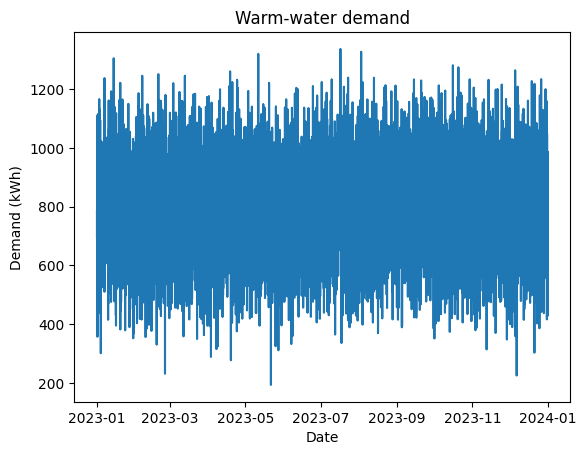

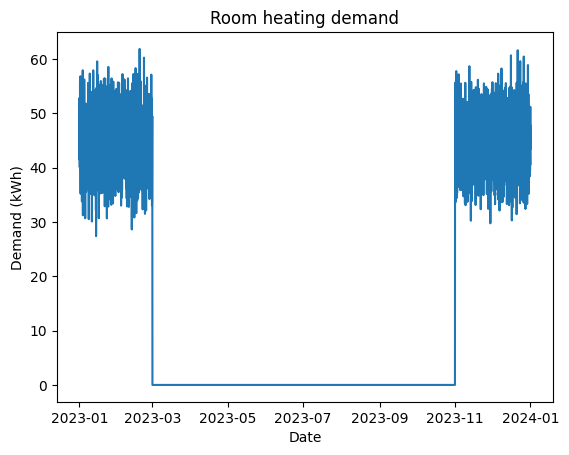

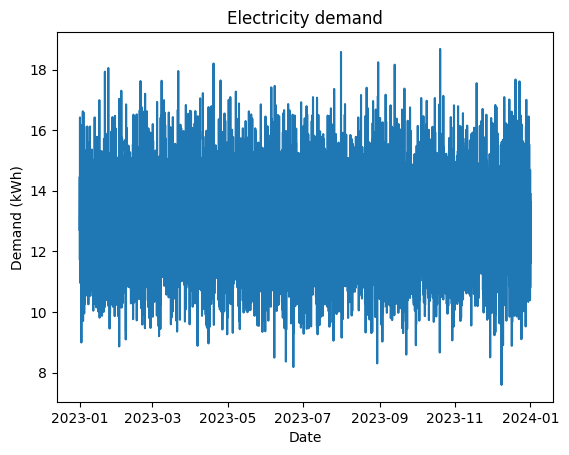

In [32]:
import matplotlib.pyplot as plt

# Plot warm-water demand as a line plot
fig, ax = plt.subplots()
ax.plot(df['Warm-water demand (kWh)'])
ax.set_title('Warm-water demand')
ax.set_xlabel('Date')
ax.set_ylabel('Demand (kWh)')
plt.show()

# Plot room heating demand as a line plot
fig, ax = plt.subplots()
ax.plot(df['Room heating demand (kWh)'])
ax.set_title('Room heating demand')
ax.set_xlabel('Date')
ax.set_ylabel('Demand (kWh)')
plt.show()

# Plot electricity demand as a line plot
fig, ax = plt.subplots()
ax.plot(df['Electricity demand (kWh)'])
ax.set_title('Electricity demand')
ax.set_xlabel('Date')
ax.set_ylabel('Demand (kWh)')
plt.show()

For dimensioning the PV-battery combination, the planner needs to determine the total elec-tricity demand in order to find the optimal level of self-sufficiency for the energy system of the building. The warm-water provision and the heat input to the space heating circuit are as-sumed to be at the same temperature level.

### Task 3.1
Calculate the electrical demand of the heat-pump at a constant Coefficient of Performance (COP) of 3.5.

$$ E_{COP,y}^{BHP} = \int \frac{Q^{WW} + Q^{RH}}{COP_y} $$

In [33]:
q_ww = warm_water_demand.sum()
q_rh = heating_demand.sum()
COP = 3.5

e_demand = (q_ww+q_rh) / COP
e_demand

2017950.3800000001

### Task 3.2
Calculate the electrical demand of the heat-pump at a variable COP with:

$$ E_{COP,t}^{BHP} = \int \frac{Q^{WW}_{t} + Q^{RH}_{t}}{COP_t} $$

<center>

t | 1:2190 | 2191:4380 | 4381:6570 | 6571:8760
--- | --- | --- | --- | ---
COP | 3.5 | 2.0 | 5.0 | 3.5

<center>

In [35]:
# Import numpy package
import numpy as np
COP_t  = np.repeat(np.array([3.5, 2.0, 5.0, 3.5]), 2190)

e_demand_var = 0
for i in range(8760):
    e_demand_var += (warm_water_demand[i]+heating_demand[i])/COP_t[i]
    
e_demand_var

2238118.662999997

### Task 3.3
What is the share of the electrical heat pump consumption in the total electrical energy consumption in the cases 3.1 and 3.2?

$$ E^{General} = \int P^{General} $$

In [37]:
share_case_1 = e_demand / electricity_demand.sum()
share_case_2 = e_demand_var / electricity_demand.sum()

print(share_case_1)
print(share_case_2)

17.690434849996677
19.620548050523976


___
## B) Solar Yield

(8760,)


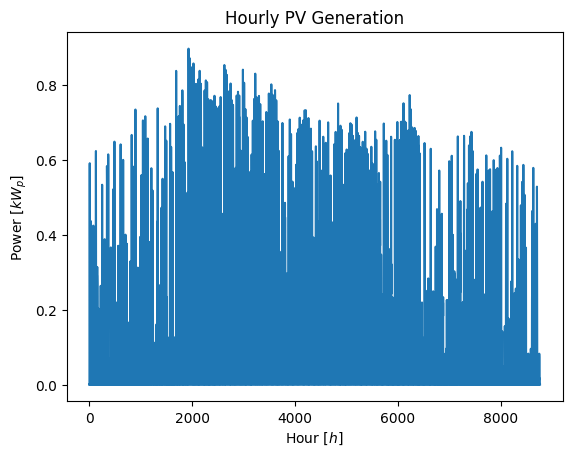

In [7]:
import json

# Load the JSON data
with open('../excercise_3/data/Timeseries_50.763_6.081_SA2_1kWp_crystSi_14_41deg_-2deg_2020_2020.json', 'r') as f:
    data = json.load(f)

# Extract the P values for each hour
hourly_data = data['outputs']['hourly']
P_values = np.array([hour['P'] for hour in hourly_data])/1000

#Unfortunately, 2020 was a leap year :-(, so we need to remove the additional day, so find the index of February 29th in the array
feb_29_index = 24 * (31 + 28) # Index of the last hour of Feb 28th

# Remove the data associated with February 29th from the array
P_values = np.delete(P_values, range(feb_29_index, feb_29_index + 24))

# Create a line plot of the P values
plt.plot(P_values)
plt.xlabel('Hour [$h$]')
plt.ylabel('Power [$kW_p$]')
plt.title('Hourly PV Generation')
plt.show()

___
## C) Economic expansion optimization
For the economic evaluation of the expansion of the building energy system with a PV system, the formulation of an optimization problem is useful. The structure of the optimization problem is generally in the form:

\begin{aligned}
& \underset{x}{\text{minimize}}
& & f(x) \\
& \text{subject to}
& & g_i(x) = 0, \quad \text{for } i \in \{1, 2, \ldots, m\} \\
&&& h_j(x) \leq 0, \quad \text{for } j \in \{1, 2, \ldots, n\} \\
\end{aligned}


where $\vec{x} = [x_1, x_2, ..., x_k]^T$ is the vector of decision variables, and $f(x)$, $g_i(x)$, and $h_j(x)$ are functions that depend on the decision variables.

The objective of the optimization problem is to minimize the objective function $f(x)$ subject to the constraints $g_i(x) = 0$ and $h_j(x) <= 0$. The equality constraints $g_i(x) = 0$ represent relationships that must be satisfied exactly, while the inequality constraints $h_j(x) <= 0$ represent limitations or bounds on the decision variables.

This general form can be used to express a wide variety of optimization problems, including linear programming, quadratic programming, and nonlinear programming problems.

## Building energy optimisation
The objective function consists of cost terms that are related to the expansion and operation of the building energy system. The main parameters for the economic evaluation are listed in the tables below:

#### Economic parameters of the PV system

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Installation costs | $c_{PV}^{tech}$ | [€] | 1000
Fixed costs | $c_{PV}^{fix,asset}$ | [€] | 300
Variable costs | $c_{PV}^{var,asset}$ | [€/$kW_p$] | 1400
Expected lifetime | T | [a] | 20

</center>

#### General economic parameters

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Electricity costs (tariff) | $c_{el}^{fuel}$ | [€/$kWh$] | 0.31
Feed-in tariff | $r_{PV}^{FIT}$ | [€/$kWh$] | 0.09
Taxes on self-consumption | $c_{PV}^{self-con}$ | [€/$kWh$] | 0.03
Internal rate of return | i | [%] | 5

</center>

In [104]:
params = {
    "c_inst" : 1000,
    "c_fix" : 300,
    "c_var" : 1400,
    "lifetime" : 20,
    "c_elec" : 0.31,
    "c_fit" : 0.09,
    "c_self" : 0.03,
    "interest_rate" : 0.05
}

## Task 3.9
Describe the economic objective of the optimization task.

## Task 3.10
What kind of decisions are associated with the mentioned optimization problem?

## Task 3.11
What kind of optimization problem results from the properties of cost assumptions and the decisions?

In [ ]:
# Define the problem data
electricity_demand = electricity_demand # in kWh per hour
pv_potential_generation = P_values # in kW

## Task 3.12
Formulate the relevant variables for the model using gurobipy.

$$ min \ z = min \ TOTEX(ANN) = min \ CAPEX(ANN) \cdot \vec{x} + OPEX(ANN) \cdot \vec{y} $$

In [91]:
import gurobipy as gp

# Create the Gurobi model
model = gp.Model("Solar_building_optimization")

# Define the decision variables
x_pv_fix = model.addVar(vtype=gp.GRB.BINARY, name="pv_if_installed")
x_pv_dim = model.addVar(vtype=gp.GRB.CONTINUOUS, name="pv_kw_installed")

In [92]:
electricity_from_grid = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="electricity_from_grid")
electricity_to_grid = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="electricity_to_grid")
electricity_from_pv = model.addVars(len(electricity_demand), vtype=gp.GRB.CONTINUOUS, lb=0, ub=gp.GRB.INFINITY, name="electricity_from_pv")

## Task 3.13
Formulate the dependency of the binary expansion decision and the discrete expansion decision of the PV system. Assume that a maximum roof area of 100 m2 can be occupied.

In [94]:
pv_max = 20
model.addConstr(x_pv_fix * pv_max >= x_pv_dim)

<gurobi.Constr *Awaiting Model Update*>

## Task 3.14
Formulate the input-output restrictions for the PV system.

In [95]:
for i in range(len(electricity_demand)):
    model.addConstr(x_pv_dim >= electricity_from_pv[i] + electricity_to_grid[i])

## Task 3.15
Formulate the energy flow balance for the electricity demand (Load coverage constraint).

In [96]:
for i in range(len(electricity_demand)):
    model.addConstr(electricity_from_grid[i] + electricity_from_pv[i] == electricity_demand[i])

## Task 3.16
For a realistic illustration, it is assumed that the degree of self-consumption of the PV electricity is limited to 30% of the load per time interval. Formulate the constraint for these conditions.

In [103]:
# for i in range(len(electricity_demand)):
#     model.addConstr(electricity_demand[i] * 0.3 >= x_pv_dim)

## Task 3.17
Calculate the objective function value without a PV system.

In [107]:
from utils import present_value_factor

pvf = present_value_factor(params["lifetime"], params["interest_rate"])

# Objective functions
obj = {}
obj["CAPEX"] = model.addVar(vtype="C", lb=-gp.GRB.INFINITY, name="CAPEX")
obj["OPEX"] = model.addVar(vtype="C", lb=-gp.GRB.INFINITY, name="OPEX")

# Define the objective function
obj["CAPEX"] = x_pv_fix * (params["c_inst"] + params["c_fix"]) / pvf + x_pv_dim * params["c_var"]
obj["OPEX"] = gp.quicksum(electricity_from_grid[i] * params["c_elec"] - electricity_to_grid[i] * params["c_fit"] + electricity_from_pv[i] * params["c_self"] for i in range(len(electricity_demand)))
            
model.setObjective(obj["CAPEX"] + obj["OPEX"], gp.GRB.MAXIMIZE)

In [108]:
model.update()

In [109]:
model

<gurobi.Model MIP instance Solar_building_optimization: 26 constrs, 42 vars, Parameter changes: Username=(user-defined)>

In [112]:
# Optimize the model
model.optimize()

# Print the results
if model.status == gp.GRB.OPTIMAL:
    print(f"PV system installed: {x_pv_dim.X}")
    # print(f"Total cost: {objective.getValue():.2f} $")
else:
    print("No solution found.")

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 26 rows, 42 columns and 75 nonzeros
Model fingerprint: 0x46d57542
Variable types: 41 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 3e+01]


Presolve removed 26 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 28182.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.818243536335e+04, best bound 2.818243536335e+04, gap 0.0000%
PV system installed: 20.0
